<a href="https://colab.research.google.com/github/coderacheal/Sunday/blob/Dev/sunday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Sunday -  Multiclass Sentiment Analysis Using Twitter tweets and ChatGPT generated text

### Train a deep learning model to detect the sentiment of a text
  - Model will be used in a react app to create a chat app the determines sentiment and warns users of the intent before message is sent

## Installations

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

## Importing relevat libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Import data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

Mounted at /content/drive


,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive


# Exploratory Data Analysis

In [ ]:
df.shape

(937854, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


In [ ]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

### Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and '\n' form tweet

##### Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re modules


In [ ]:
# before
df['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [ ]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


df['Text'] = df['Text'].apply(remove_usernames)
df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
1,: Como dos gotas de agua: Joven se disfraza de...,es,negative
2,Flagstar Bank discloses a data breach that im...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,ACCIDENT: Damage Only - Raleigh Fire Departme...,en,negative
937852,So happy for her! She’s been incredible.,en,positive


In [ ]:
# after
df['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [ ]:
# corresponding label
df['Label'][0]

'litigious'

Next, hashtags
- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [ ]:
#before

df['Text'][1]

': Como dos gotas de agua: Joven se disfraza de Bad Bunny y causa tumulto en alfombra roja. '

In [ ]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


df['Text'] = df['Text'].apply(remove_hastags)
df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
1,: Como dos gotas de agua: Joven se disfraza de...,es,negative
2,Flagstar Bank discloses a data breach that im...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,ACCIDENT: Damage Only - Raleigh Fire Departme...,en,negative
937852,So happy for her! She’s been incredible.,en,positive


In [ ]:
# after
df['Text'][1]

': Como dos gotas de agua: Joven se disfraza de Bad Bunny y causa tumulto en alfombra roja. '

##### Next, http links

- We need to remove all http links.
- Write a function using the re module

In [ ]:
#before
df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. Find out more: '

In [ ]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

df['Text'] = df['Text'].apply(remove_urls)

In [ ]:
#after
df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n'


##### Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [ ]:
#before
df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. Find out more: '

In [ ]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['Text'] = df['Text'].apply(remove_special_chars)
df.head()

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
1,: Como dos gotas de agua: Joven se disfraza de...,es,negative
2,Flagstar Bank discloses a data breach that im...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


In [ ]:
#after
df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. Find out more: '

## Let's use just the English Tweets

In [ ]:
english_df = df[df['Language'] =='en']

#let's drop the language column
english_df.drop(columns='Language', inplace=True)

## 100,000 records from the dataset. 25,000 for each class

  - Upon inspection, the ligitious class needs to be engineered as it is too context heavy

In [ ]:
uncertainty_df = english_df[df['Label'] =='uncertainty'][:25000]
positive_df = english_df[df['Label'] =='positive'][:25000]
negative_df = english_df[df['Label'] =='negative'][:25000]
litigious_df = english_df[df['Label'] =='litigious'][:2500]

In [ ]:
litigious_df.head()

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,Flagstar Bank discloses a data breach that im...,litigious
4,OOPS. I typed her name incorrectly (today’s br...,litigious
14,"[When the first sign of surrender comes, Micha...",litigious
27,"""It's Your fight to save the UK from the liars...",litigious


In [ ]:
# The litigious texts are not very clear. We will engineer some litigious comments with generated text from ChatGPT

uncertainty_df['Text'][7]

'you can also relate this to art too!!! a lot of people are dismayed in starting art because of this kind of thing and i always try to tell them that everyone starts somewhere and those who are "good" by certain ages just trained enough to get there, like with anything you learn'

## Feature Engineering

 - Engineer the litigious label to make it more extensive

In [ ]:
new_records = []

litigious_sentences = [
    'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.',
    'The company is facing a lawsuit for patent infringement due to their unauthorized use of a patented technology.',
    'The accused party is being sued for breach of contract, as they failed to fulfill their obligations as outlined in the signed agreement.',
    'I will bury this place in so much law suit that your grand children are going to need lawyers',
    'The plaintiff claims substantial damages resulting from the defendant\'s fraudulent activities, including misrepresentation of financial information.',
    'The employer is facing a legal battle over allegations of wrongful termination and violation of labor laws, as the employee argues they were fired without just cause.',
    'The plaintiff seeks compensation for the alleged negligence of the defendant, which resulted in personal injury and financial loss.',
    'The company filed a lawsuit against its former employee for alleged misappropriation of trade secrets, claiming significant damages.',
    'The court issued an injunction to prevent the defendant from further trademark violation and ordered them to cease all unauthorized use of the protected mark.',
    'The plaintiff accuses the defendant of libel and slander, claiming that the false statements made by the defendant harmed their personal and professional reputation.',
    'The dispute between the two parties arose from an alleged breach of fiduciary duty, with the plaintiff asserting that the defendant prioritized personal gain over their legal obligations.',
    'The neighbors filed a complaint against each other for alleged trespassing, seeking a restraining order to prevent further disputes.',
    'The landlord is facing a lawsuit from the tenant, claiming breach of contract due to the landlord\'s failure to address necessary repairs in a timely manner.',
    'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
    'The homeowners\' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.',
    'Siblings engaged in a dispute over their late parent\'s estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets.',
    "The defendant's negligent actions directly resulted in severe harm and emotional distress, warranting a substantial compensatory award.",
    "The plaintiff firmly believes that the defendant's misleading advertising practices constitute false representation, leading to consumer deception and unfair competition.",
    "The plaintiff asserts that the defendant's infringement of intellectual property rights demonstrates a blatant disregard for established patents, trademarks, and copyrights.",
    "The plaintiff alleges that the defendant's discriminatory practices, based on gender and age, violated fundamental human rights, causing undue hardship and systemic bias.",
]

for i in range(1125):
  for sentence in litigious_sentences:
    text = sentence
    label = 'litigious'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_litigious_df = pd.DataFrame(new_records)


In [ ]:
engineered_litigious_df.head()

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious


In [ ]:
engineered_litigious_df.shape

(22500, 2)

In [ ]:
data = pd.concat([litigious_df, uncertainty_df, positive_df, negative_df, engineered_litigious_df], axis=0, ignore_index=True)
data

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
1,Flagstar Bank discloses a data breach that im...,litigious
2,OOPS. I typed her name incorrectly (today’s br...,litigious
3,"[When the first sign of surrender comes, Micha...",litigious
4,"""It's Your fight to save the UK from the liars...",litigious
...,...,...
99995,Siblings engaged in a dispute over their late ...,litigious
99996,The defendant's negligent actions directly res...,litigious
99997,The plaintiff firmly believes that the defenda...,litigious
99998,The plaintiff asserts that the defendant's inf...,litigious


## Visualize the balance

In [ ]:
sentiments = data['Label'].value_counts().sort_values(ascending=False)
sentiments

litigious      25000
uncertainty    25000
positive       25000
negative       25000
Name: Label, dtype: int64

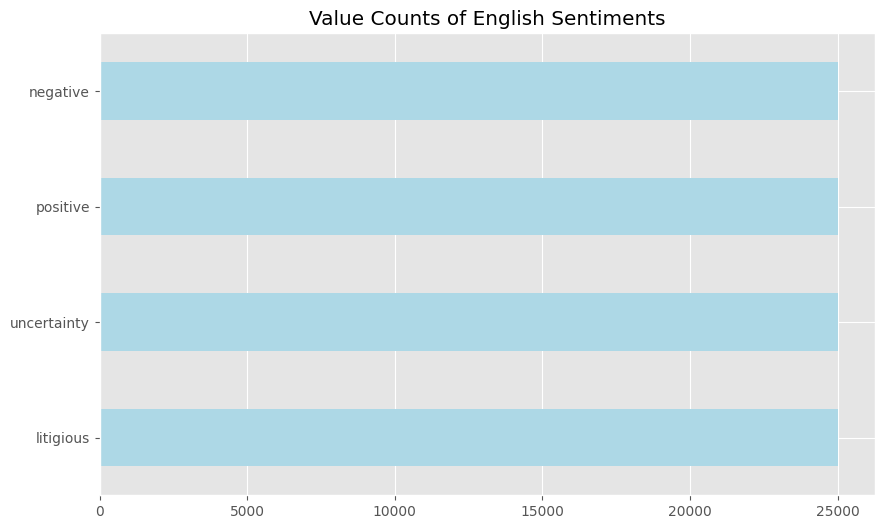

In [ ]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

### Let's shuffle the dataset because of the engineering we did

In [ ]:
suffled_data = data.sample(frac=1, random_state=42)  # Frac=1 ensures all rows are included, random_state for reproducibility

suffled_data.head()


,Text,Label
48298,I'm soooo excited for this!,positive
81047,The company filed a lawsuit against its former...,litigious
92754,The homeowners' association sent a cease and d...,litigious
46007,not everyone can make “3 dollars and a dream” ...,positive
76981,To answer the beads question.. there were way ...,negative


# Let's Train a Bert Model with a quarter million Tweets

#### Creating Tokenizer and Model

Let's convert our text and label column into a list for easy splitting



In [ ]:
X = data['Text'].to_list()
y = data['Label'].to_list()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = torch.tensor(train_labels)

In [ ]:
# Tokenize and encode the test texts
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = torch.tensor(label_encoder.transform(y_test))

## Create Train and Test Datasets

In [ ]:
# Create train and test datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [ ]:
#Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Set training parameters
num_epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
#Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluation loop
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy().tolist())


In [ ]:
# evaluate perfomance of model
model.eval()

# Initialize lists for storing true labels and predicted labels
true_labels = []
predicted_labels = []

# Initialize list for storing predicted probabilities
predicted_probs = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_classes = logits.argmax(dim=1)
        probabilities = torch.softmax(logits, dim=1)

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted_classes.tolist())

        # Store predicted probabilities
        predicted_probs.extend(probabilities.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9742
Precision: 0.974220914718252
Recall: 0.9742
F1 Score: 0.9741941986719596


In [ ]:
# Input text for prediction
input_text = "I need a contract before I can say anything"

# Tokenize and encode the input text
input_encoding = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = logits.argmax(dim=1)

# Convert predicted labels back to original classes using label_encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels.cpu().numpy())

# Print the predicted class
print("Predicted class:", predicted_classes[0])


Predicted class: litigious


### Persist Model

In [ ]:
# Save the model

model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sunday-model')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer')


('/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/sunday-tokenizer/tokenizer.json')